### Example finding flares via HEK and then getting GOES/XRS15 data

Note: several ways of doing and plotting this. The following works but there be more "optimal" ways.

Other resources
* [Sunpy doc on goes flare list from HEK](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/querying_the_GOES_event_list.html#sphx-glr-generated-gallery-acquiring-data-querying-the-goes-event-list-py)
* [Sunpy doc on getting/plotting XRS](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/goes_xrs_example.html#sphx-glr-generated-gallery-acquiring-data-goes-xrs-example-py)


22-10-21   IGH

---

In [1]:
#  Import in the usual stuff
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from astropy.time import Time
from astropy.time import TimeDelta

#  Here just assuming it save to your sunpy/data dir but can of course change
outdir='/Users/iain/sunpy/data/'


In [2]:
# Let's look for all the X-class flares in 2017
trange=a.Time("2017-01-01 00:00","2018-01-01 00:00")
res = Fido.search(trange,a.hek.EventType("FL"),a.hek.FL.GOESCls > "X1.0",a.hek.OBS.Observatory == "GOES")
hekres = res["hek"]

In [3]:
#  Four X-class flares in 2017 and lot's of info in the HEK about them
hekres

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs [2]
str1,str1,str125,str5,str21,str12,object,str29,object,str1,object,str27,str41,str19,str1,str2,object,object,float64,str25,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str95,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str23,str1,object,object,str4,object,str4,str4,str1,float64,str1,float64,str61,str110,str1,str1,str1,object,str1,str20,object,object,object,str1,str1,str1,object,object,str19,str7,float64,float64,str4,object,str19,str11,object,str20,str1,object,str1,str1,str2,str66,str4,float64,int64,object,float64,str1,str1,object,str5,int64,float64,object,int64,str1,str1,int64,str4,str1,str1,str4,int64,str1,str19,str19,object,int64,object,int64,str4,object,str5,str1,str1,object,float64,float64,str19,int64,str1,str4,str13,str1,object,object,str1,str1,object,str1,str3,object,str66,str1,str1,object
,0,"POLYGON((508.749012 -224.378094,522.585918 -223.233288,523.716606 -207.039474,509.849808 -208.186056,508.749012 -224.378094))",false,POINT(116.929197 -7),UTC-HGS-TOPO,None,POINT(516.264948 -215.721384),None,,None,"SSWIDL get_gev, ..., ngdc=0",POINT(0.588075322199437 247.322381781107),2017-09-06T08:57:00,,FL,None,None,5e-08,http://www.swpc.noaa.gov/,,,false,,true,None,None,,,None,,010300000001000000050000000CFFE9060AD17940EC3026FDBDEE73C00CFFE9060AD17940162AFF5A5E215CC0BA32A836B85B8340162AFF5A5E215CC0BA32A836B85B8340EC3026FDBDEE73C00CFFE9060AD17940EC3026FDBDEE73C0,"POLYGON((116.429197 -7.5,117.429197 -7.5,117.429197 -6.5,116.429197 -6.5,116.429197 -7.5))",None,,XRA,,,SOL2017-09-06T08:57:00L116C097,None,9,,,,SWPC.Webmaster@noaa.gov,,None,None,SWPC,None,SWPC,GOES,,-6.5,,-7.5,"U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center","POLYGON((0.584406 246.200656,0.597268 246.869256,0.591894 248.42976,0.57882 247.788421,0.584406 246.200656))",,,,None,,0.844000000000000083,None,None,None,,,,None,None,2017-09-06T00:00:00,degrees,-215.721384,516.264948,GOES,None,2017-09-06T17:36:04,cheung_mark,None,0.887617077621888351,,None,,,cm,ivo://helio-informatics.org/FL_SWPC_20170906_173603_20170906085700,SWPC,33.5,12673,None,32.5,,,None,false,1,0.588075322199437,None,-7,,,33

In [4]:
shrt_res = hekres["event_starttime", "event_peaktime",
                        "event_endtime", "fl_goescls", "ar_noaanum"]
shrt_res

event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum
str19,str19,str19,str4,int64
2017-09-06T08:57:00,2017-09-06T09:10:00,2017-09-06T09:17:00,X2.2,12673
2017-09-06T11:53:00,2017-09-06T12:02:00,2017-09-06T12:10:00,X9.3,12673
2017-09-07T14:20:00,2017-09-07T14:36:00,2017-09-07T14:55:00,X1.3,12673
2017-09-10T15:35:00,2017-09-10T16:06:00,2017-09-10T16:31:00,X8.2,12673


In [5]:
# Now get the XRS data for the second flare (first missing in G15 data)
# Want data for +/-10 mins of flare, using astopy time to do this (easier sunpy way?)

gtstart=Time(shrt_res[1]["event_starttime"],scale='utc')-TimeDelta(10*60,format='sec')
gtend=Time(shrt_res[1]["event_endtime"],scale='utc')+TimeDelta(10*60,format='sec')
print(gtstart)
print(gtend)

# Search and get the XRS data
trange=a.Time(gtstart.iso,gtend.iso)
rg15 = Fido.search(trange, a.Instrument("XRS"), a.goes.SatelliteNumber(15))
print(rg15)
fg15 = Fido.fetch(rg15,path=outdir)

2017-09-06T11:43:00.000
2017-09-06T12:20:00.000
Results from 1 Provider:

1 Results from the XRSClient:
       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2017-09-06 00:00:00.000 2017-09-06 23:59:59.999        XRS ...   GOES     NOAA




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [6]:
# Load data file in, truncate to desired time range 
fg15=glob.glob(outdir+'*g15*20170906*.nc')
g15 = ts.TimeSeries(fg15, concatenate=True)
tg15=g15.truncate(trange.start.iso,trange.end.iso)

tg_tims=tg15.index
tg_x05=tg15.quantity("xrsa").value
tg_x18=tg15.quantity("xrsb").value


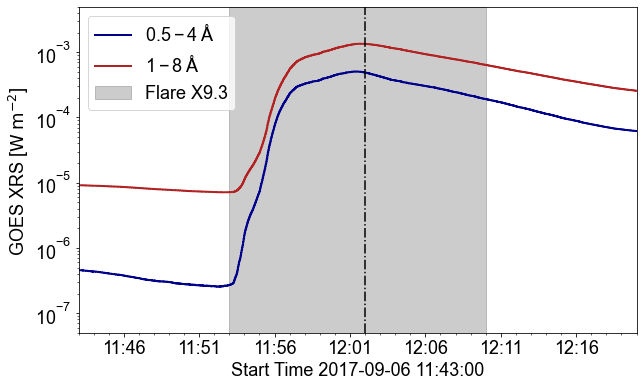

In [7]:
# And then plot it all

tfl=a.Time(shrt_res[1]["event_starttime"],shrt_res[1]["event_endtime"])

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,tg_x05,drawstyle='steps-post',marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')
plt.plot(tg_tims,tg_x18,drawstyle='steps-post',marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')

ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Start Time "+trange.start.iso[:-4])
ax.set_yscale("log")
ax.set_ylim([5e-8,5e-3])
ax.set_xlim([trange.start.datetime,trange.end.datetime])
# precisely control the x time labels
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)

ax.axvline(shrt_res[1]["event_peaktime"],color='black',ls='-.')
ax.axvspan(tfl.start.datetime,tfl.end.datetime,color='black',alpha=0.2, label='Flare '+shrt_res[1]["fl_goescls"])

plt.legend()
# plt.tight_layout()
# plt.savefig('xflare.pdf')
plt.show()